# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

**Collab setting**

In [2]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
#!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

In [2]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)


In [3]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [4]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [5]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [6]:
def plot_gallery(images, h, w, n_row=3, n_col=6, suptitle=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    if suptitle is not None:
        plt.suptitle(suptitle)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

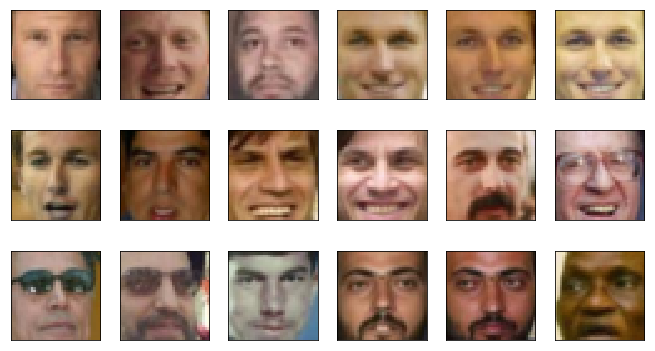

In [7]:
plot_gallery(X_train, image_h, image_w)

In [8]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [9]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# https://stackoverflow.com/a/49433937/11347890

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #TODO
        
        self.encoder = nn.Sequential(
            nn.Linear(3888, 1024),
            nn.ReLU(),
            nn.Linear(1024, dimZ)
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3888),
            nn.Sigmoid()
        )
        
        self.encoder.apply(init_weights)
        self.decoder.apply(init_weights)
        
    def forward(self, x):
        
        #TODO
        
        latent_code = self.encoder.forward(x)
        reconstruction = self.decoder.forward(latent_code)
        
        return reconstruction, latent_code

In [10]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

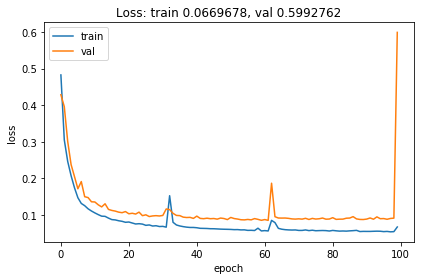

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:49<00:00,  4.68s/it]


Best val loss: 0.0850244, epoch 61


In [11]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from copy import deepcopy
from IPython import display
from tqdm import trange
import random

def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

train_size = len(train_loader)
val_size = len(val_loader)

def train(model, optimizer, epochs_n=30, batch_size=32):
    model_best = None
    models = []
    model.to(device)
    
    train_loss_curve = [np.nan] * epochs_n
    val_loss_curve = [np.nan] * epochs_n
    min_val_loss = 1e10
    min_val_loss_epoch = 0
    
    n_batches_train = (train_size - 1) // batch_size + 1
    n_batches_val = (val_size - 1) // batch_size + 1

    for epoch in trange(epochs_n):
        model.train()

        train_loss_curve[epoch] = 0
        
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            prediction = model(x)[0]
            
            train_loss = criterion(prediction, x)
            train_loss_curve[epoch] += train_loss.item()
            train_loss.backward()
            optimizer.step()

        display.clear_output(wait=True)

        train_loss_curve[epoch] /= n_batches_train
        plt.plot(train_loss_curve, label='train')

        model.eval()

        val_loss_curve[epoch] = 0
        for x, _ in val_loader:
            x = x.to(device)
            prediction = model(x)[0]

            val_loss = criterion(prediction, x)
            val_loss_curve[epoch] += val_loss.item()
        
        val_loss_curve[epoch] /= n_batches_val
        plt.plot(val_loss_curve, label='val')
        plt.title('Loss: train {:.7f}, val {:.7f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        plt.legend()
        
        if val_loss_curve[epoch] < min_val_loss:
            min_val_loss = val_loss_curve[epoch]
            min_val_loss_epoch = epoch
            model_best = deepcopy(model)
        
        if epoch % 5 == 0:
            models.append(deepcopy(model))
        
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.tight_layout()
        plt.show()
    
    print('Best val loss: {:.7f}, epoch {}'.format(min_val_loss, min_val_loss_epoch))
    
    return model_best, models

set_random_seeds(device=device)
autoencoder, models = train(autoencoder, optimizer, epochs_n=100)

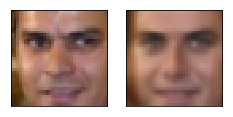

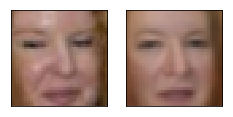

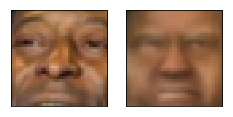

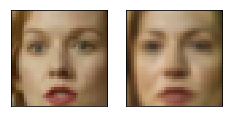

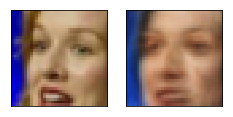

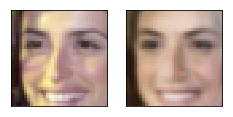

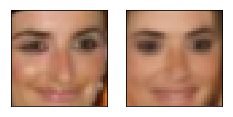

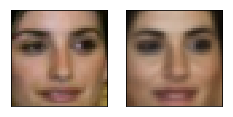

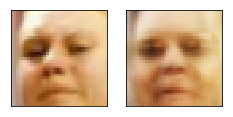

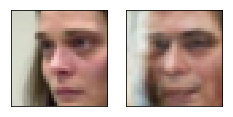

In [12]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0].cuda())
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

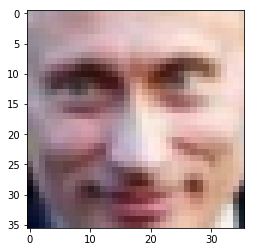

In [13]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

In [14]:
image_progress = [m(putin.cuda())[0] for m in models]

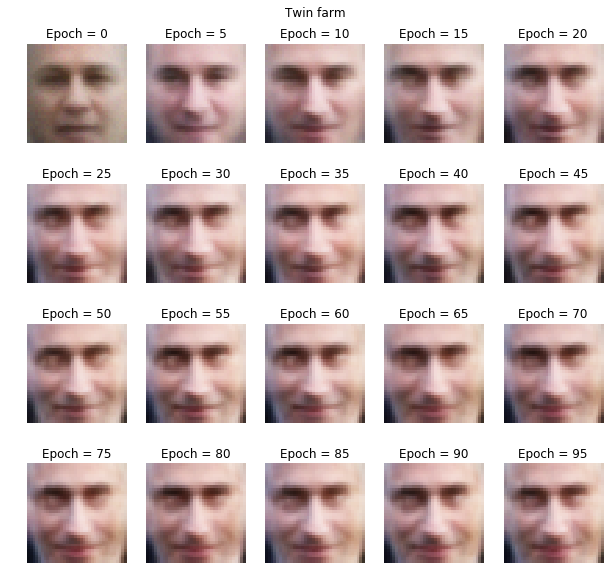

In [15]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5))
    plt.axis('off')
plt.subplots_adjust(top=0.95)
plt.show()

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

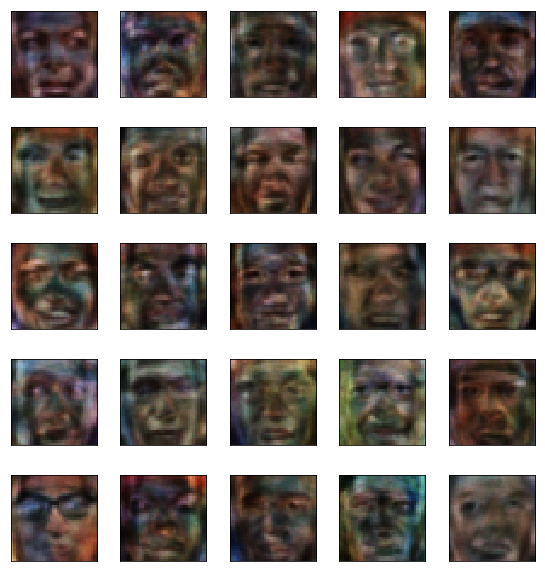

In [16]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(Variable(torch.from_numpy(z)).cuda())
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [17]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(3888, 1024)
        self.fc21 = nn.Linear(1024, dimZ)
        self.fc22 = nn.Linear(1024, dimZ)
        self.fc3 = nn.Linear(dimZ, 1024)
        self.fc41 = nn.Linear(1024, 3888)
        self.fc42 = nn.Linear(1024, 3888)
        
        self.fc1.apply(init_weights)
        self.fc21.apply(init_weights)
        self.fc22.apply(init_weights)
        self.fc3.apply(init_weights)
        self.fc41.apply(init_weights)
        self.fc42.apply(init_weights)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc41(h3)), self.fc42(h3)

    def forward(self, x):
        
        #TODO
        latent_mu, latent_logsigma = self.encode(x.view(-1, 3888))
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(z)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)= -\sum_{i=1}^{dimX} \Big(\frac{(\mu_i-x)^2}{2\sigma_i^2} + \log \sigma_i + \log \sqrt{2\pi} \Big)$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

_Outputting $\sigma$, we couldn't guarantee that this variable is non-negative so that we can actually use it as a standard deviation. Instead, we can output $u = \log(\sigma)$ and then take $\sigma = \exp(u)$ as a standard deviation, which is definitely non-negative._

In [18]:
import math

def KL_divergence(mu, logsigma):
    return -(torch.sum(1 + 2 * logsigma - mu ** 2 - logsigma.exp() ** 2, dim=1) / 2).mean()

def log_likelihood(x, mu, logsigma):
    return -torch.sum(
        (mu - x) ** 2 / (2 * torch.exp(logsigma) ** 2) + logsigma + torch.tensor(math.log(2 * math.pi) / 2),
        dim=1
    ).mean()

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

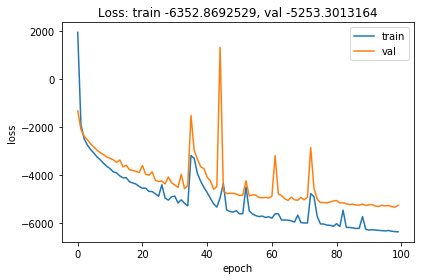



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:21<00:00,  8.65s/it]

Best val loss: -5330.7089000, epoch 98


In [21]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

vae = VAE().cuda()

# Use Adam optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.0001)


def train_vae(model, optimizer, epochs_n=30, batch_size=1):
    model_best = None
    model.to(device)
    
    train_loss_curve = [np.nan] * epochs_n
    val_loss_curve = [np.nan] * epochs_n
    min_val_loss = 1e10
    min_val_loss_epoch = 0
    
    n_batches_train = (train_size - 1) // batch_size + 1
    n_batches_val = (val_size - 1) // batch_size + 1

    for epoch in trange(epochs_n):
        model.train()

        train_loss_curve[epoch] = 0
        
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = model(x)
            
            train_loss = loss_vae(x, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma)
            train_loss_curve[epoch] += train_loss.item()
            train_loss.backward()
            optimizer.step()

        display.clear_output(wait=True)

        train_loss_curve[epoch] /= n_batches_train
        plt.plot(train_loss_curve, label='train')

        model.eval()

        val_loss_curve[epoch] = 0
        for x, _ in val_loader:
            x = x.to(device)
            reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = model(x)

            val_loss = loss_vae(x, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma)
            val_loss_curve[epoch] += val_loss.item()
        
        val_loss_curve[epoch] /= n_batches_val
        plt.plot(val_loss_curve, label='val')
        plt.title('Loss: train {:.7f}, val {:.7f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        plt.legend()
        
        if val_loss_curve[epoch] < min_val_loss:
            min_val_loss = val_loss_curve[epoch]
            min_val_loss_epoch = epoch
            model_best = deepcopy(model)
    
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.tight_layout()
        plt.show()
    
    print('Best val loss: {:.7f}, epoch {}'.format(min_val_loss, min_val_loss_epoch))
    
    return model_best

set_random_seeds(device=device)
vae = train_vae(vae, optimizer, epochs_n=100)

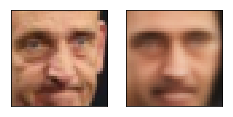

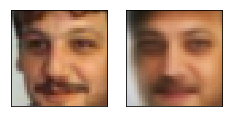

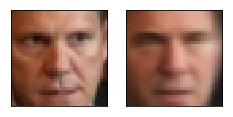

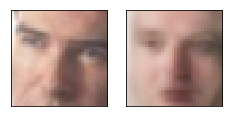

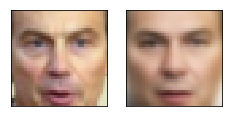

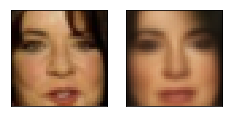

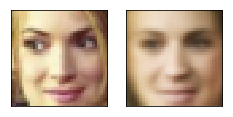

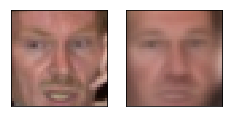

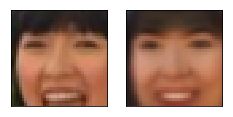

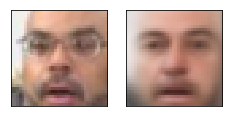

In [22]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0].cuda())
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

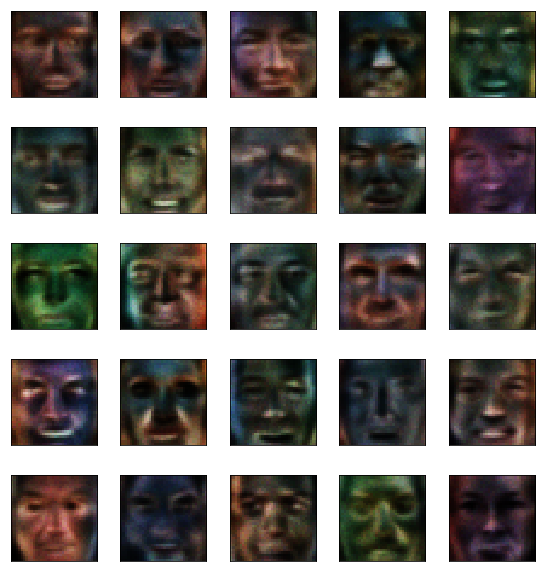

In [29]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

vae.eval()
z = (np.random.randn(25, dimZ)).astype('float32')
output = vae.decode(Variable(torch.from_numpy(z)).cuda())[0]
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## If you are going to do part 4 (presicion-recall score): 

In [46]:
# using your model, generate face set with len = len(data)
data, _ = fetch_lfw_dataset(dimx=36,dimy=36)
z = (np.random.randn(len(data), dimZ)).astype('float32')
output = vae.decode(Variable(torch.from_numpy(z)).cuda())[0].cpu().detach().numpy()
answ = output.reshape(output.shape[0], 36*36*3)

## Save it ot npz

In [47]:
np.savez("vae.npz", Pictures=answ)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [50]:
smiling_idx = np.random.choice(attrs[attrs['Smiling'] > 0].index, size=10, replace=False)
non_smiling_idx = np.random.choice(attrs[attrs['Smiling'] < 0].index, size=10, replace=False)

data_smiling = data[smiling_idx].reshape(-1, 3888).astype(np.float64) / 255
data_non_smiling = data[non_smiling_idx].reshape(-1, 3888).astype(np.float64) / 255

In [51]:
ae_z_smiling = autoencoder.encoder(torch.from_numpy(data_smiling).float().cuda()).mean(dim=0)
ae_z_non_smiling = autoencoder.encoder(torch.from_numpy(data_non_smiling).float().cuda()).mean(dim=0)
ae_z_diff = (ae_z_smiling - ae_z_non_smiling).cpu().detach()
ae_z_diff

tensor([ 3.6353e-02, -2.4370e-02, -1.7202e-04, -2.1453e-01, -2.3003e-01,
         1.3508e-01,  2.8446e-01,  1.5714e-01, -7.6167e-03, -1.2362e-01,
         1.6552e-01, -1.1615e-02, -2.9977e-01,  2.7792e-01,  2.0571e-01,
         1.4016e-01, -1.5179e-01,  5.4494e-02, -6.3584e-02, -1.9592e-01,
        -1.0936e-01, -7.3575e-02,  3.0320e-01, -5.4811e-01, -5.3596e-02,
         1.8070e-01, -6.4779e-02,  2.5481e-02,  1.1415e-01,  3.7416e-01,
        -1.0806e-01,  5.1017e-02,  1.0717e-01, -3.5159e-02, -1.8442e-01,
        -1.1190e-01,  1.3827e-01,  2.5155e-01,  1.6243e-01,  9.6913e-02,
         8.7615e-02,  1.2792e-01, -4.5086e-03,  1.6205e-01,  1.8751e-01,
         2.9448e-01, -1.4576e-01, -3.0858e-01,  2.9140e-01,  1.1965e-01,
        -3.0422e-01, -4.8008e-02,  2.1678e-01, -2.4275e-01,  2.1613e-01,
        -8.6682e-02,  4.0640e-02,  3.2111e-01,  5.8374e-02, -1.3407e-01,
         4.1377e-03, -6.8591e-02,  1.3783e-01,  1.5545e-01,  6.5783e-02,
        -3.1582e-01, -1.8103e-01,  9.8031e-03, -2.1

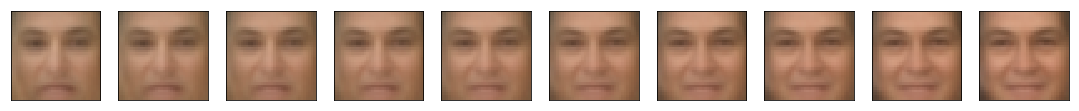

In [52]:
ae_z_smiling_transforms = ae_z_non_smiling.repeat(10, 1) + (torch.linspace(0, 1, 10).view(-1, 1) * ae_z_diff.repeat(10, 1)).cuda()
output = autoencoder.decoder(ae_z_smiling_transforms)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=1, n_col=10)

In [53]:
vae_z_smiling = vae.encode(torch.from_numpy(data_smiling).float().cuda())[0].mean(dim=0)
vae_z_non_smiling = vae.encode(torch.from_numpy(data_non_smiling).float().cuda())[0].mean(dim=0)
vae_z_diff = (vae_z_smiling - vae_z_non_smiling).cpu().detach()
vae_z_diff

tensor([ 0.0573,  0.2338,  0.0854,  0.0147, -0.0143,  0.1621,  0.0007,  0.1154,
        -0.2167, -0.0884,  0.2431,  0.1835, -0.0957,  0.0572, -0.0640, -0.1896,
        -0.1416, -0.0126,  0.0608, -0.0237, -0.0787, -0.2424,  0.1404,  0.2798,
         0.1222, -0.0296, -0.0475,  0.0158, -0.1360, -0.0118, -0.1013,  0.1395,
         0.1040, -0.0420, -0.2184, -0.1069,  0.0189, -0.0952, -0.1304,  0.0260,
        -0.0130,  0.0046,  0.2253,  0.1996,  0.0805, -0.1208,  0.1257, -0.1600,
         0.1464,  0.1406,  0.0127, -0.0570, -0.2168,  0.1196, -0.1836, -0.1461,
        -0.0749,  0.2537, -0.1830,  0.1063,  0.0447, -0.0645,  0.1746, -0.2517,
         0.0347,  0.0030,  0.1267,  0.0907, -0.0006, -0.0766, -0.0997, -0.1258,
        -0.0865,  0.0144,  0.0164,  0.0717,  0.0467, -0.3279, -0.1290,  0.2376,
         0.0173,  0.1097, -0.1243, -0.0353, -0.0412, -0.0325,  0.0177, -0.1905,
         0.0989,  0.0224,  0.0040, -0.0673,  0.0743, -0.0033, -0.1128,  0.0336,
        -0.0189, -0.0163,  0.1767, -0.01

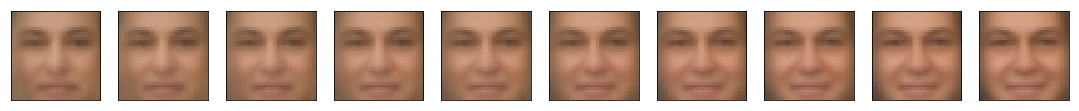

In [54]:
vae_z_smiling_transforms = vae_z_non_smiling.repeat(10, 1) + (torch.linspace(0, 1, 10).view(-1, 1) * vae_z_diff.repeat(10, 1)).cuda()
output = vae.decode(vae_z_smiling_transforms)[0]
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=1, n_col=10)

General function for all the attributes:

In [55]:
def attr_transform(attribute, model, n_samples=10):
    """
    attribute: attribute to transform, column name
    model: AE of VAE
    n_samples: number of samples to compute z vectors from
    """
    attr_idx = np.random.choice(attrs[attrs[attribute] > 0].index, size=n_samples, replace=False)
    non_attr_idx = np.random.choice(attrs[attrs[attribute] < 0].index, size=n_samples, replace=False)

    data_attr = data[attr_idx].reshape(-1, 3888).astype(np.float64) / 255
    data_non_attr = data[non_attr_idx].reshape(-1, 3888).astype(np.float64) / 255
    
    assert model in [autoencoder, vae]
    if model == autoencoder:
        z_attr = model.encoder(torch.from_numpy(data_attr).float().cuda()).mean(dim=0)
        z_non_attr = model.encoder(torch.from_numpy(data_non_attr).float().cuda()).mean(dim=0)
    elif model == vae:
        z_attr = model.encode(torch.from_numpy(data_attr).float().cuda())[0].mean(dim=0)
        z_non_attr = model.encode(torch.from_numpy(data_non_attr).float().cuda())[0].mean(dim=0)
    
    z_diff = (z_attr - z_non_attr).cpu().detach()
    z_attr_transforms = z_non_attr.repeat(10, 1) + (torch.linspace(0, 1, 10).view(-1, 1) * z_diff.repeat(10, 1)).cuda()
    suptitle = 'Non-' + attribute + ' -> ' + attribute
    if model == autoencoder:
        output = model.decoder(z_attr_transforms)
        suptitle += ', AE'
    elif model == vae:
        output = model.decode(z_attr_transforms)[0]
        suptitle += ', VAE'
    
    plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=1, n_col=10, suptitle=suptitle)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


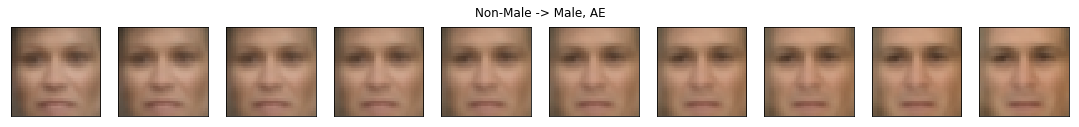

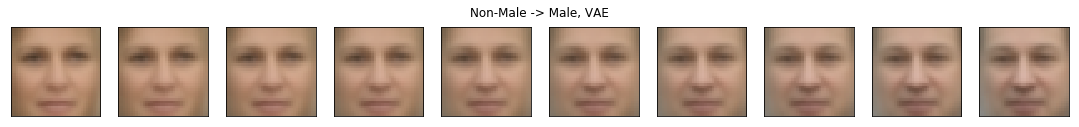

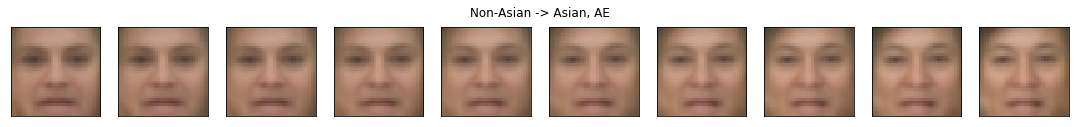

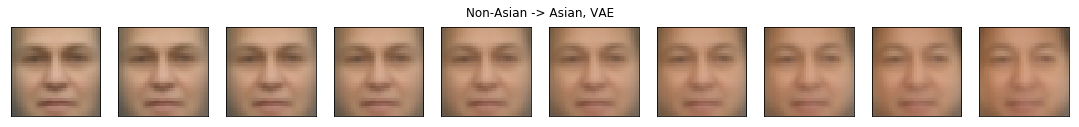

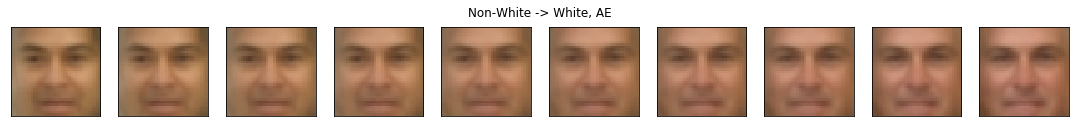

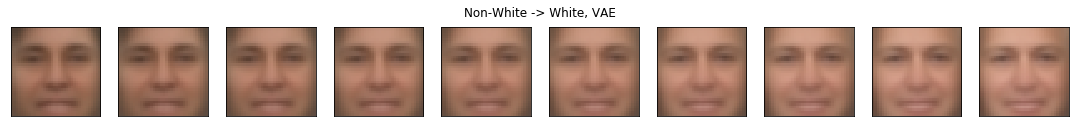

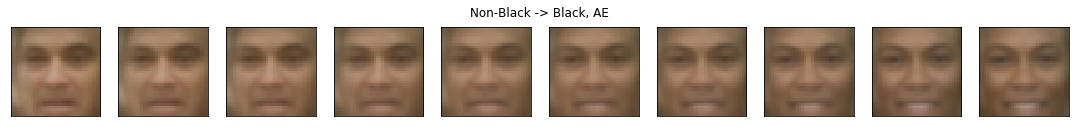

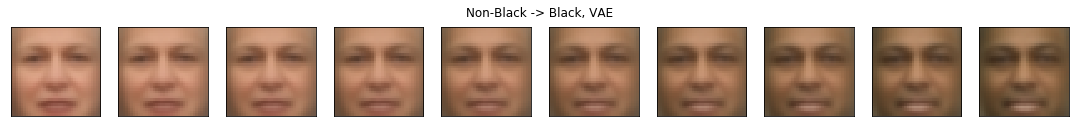

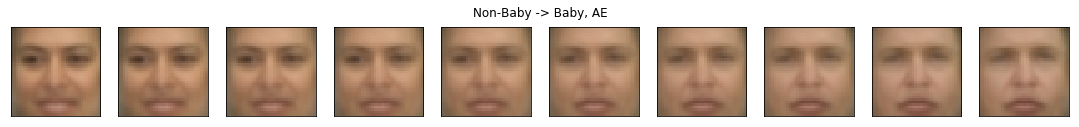

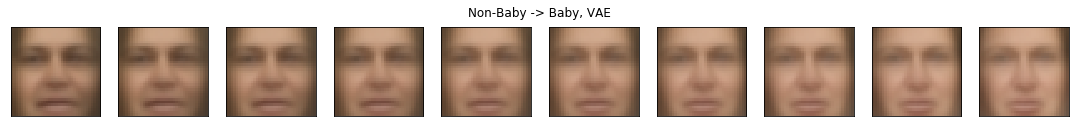

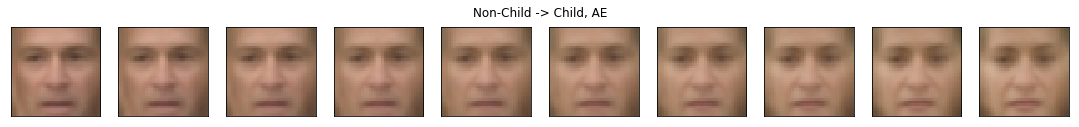

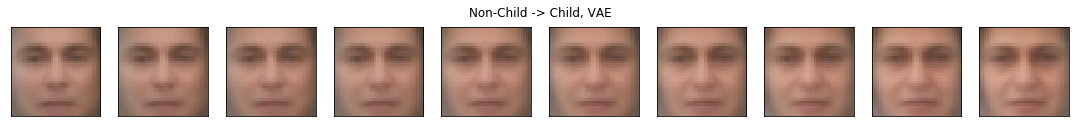

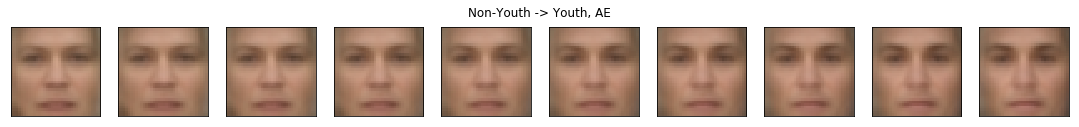

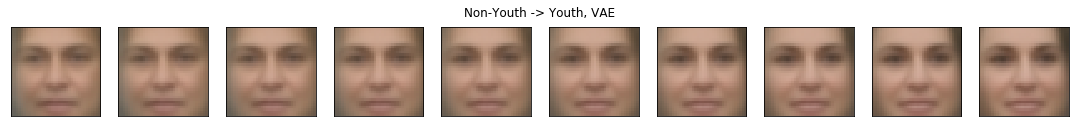

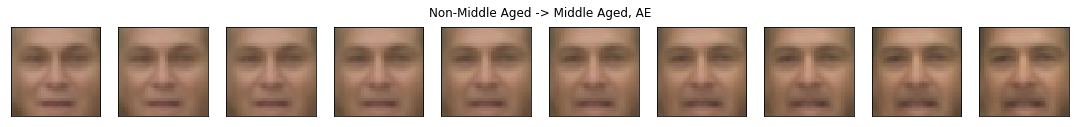

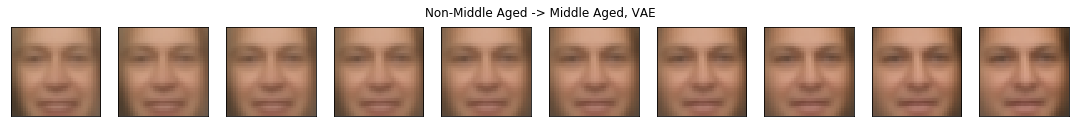

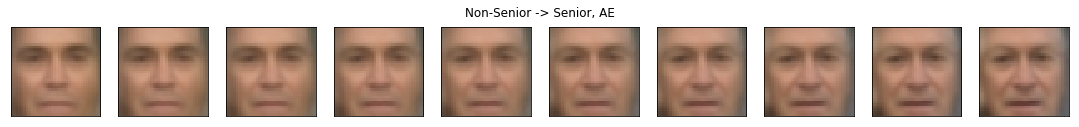

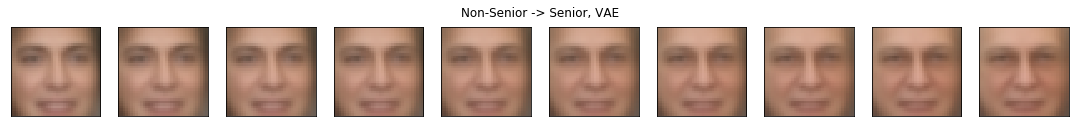

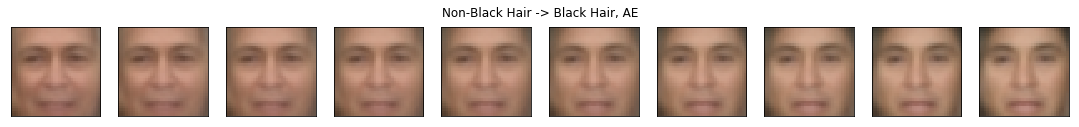

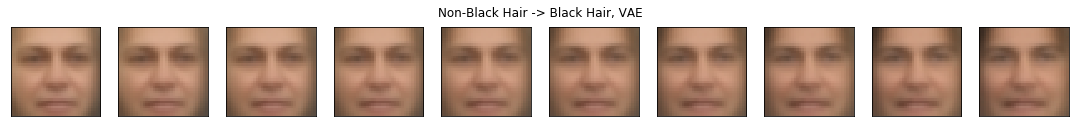

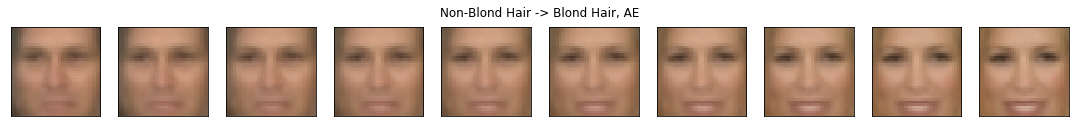

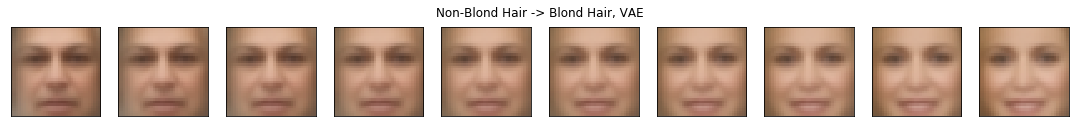

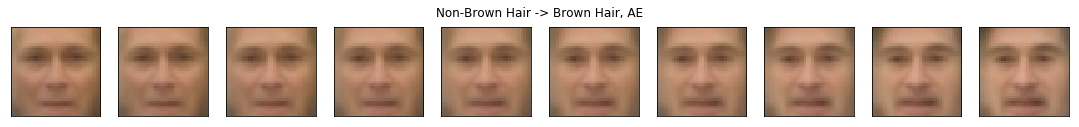

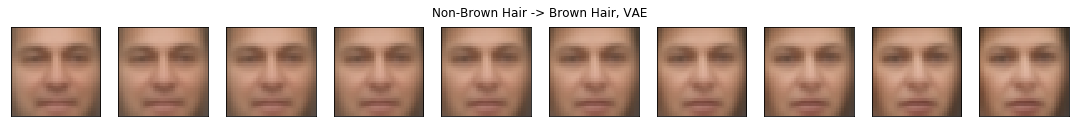

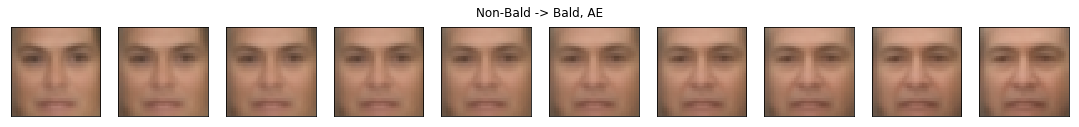

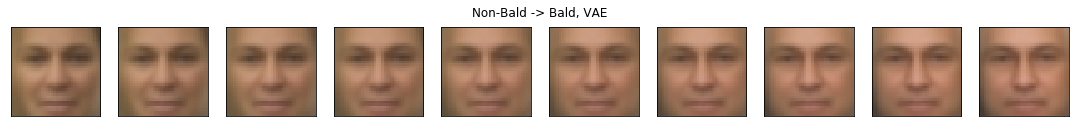

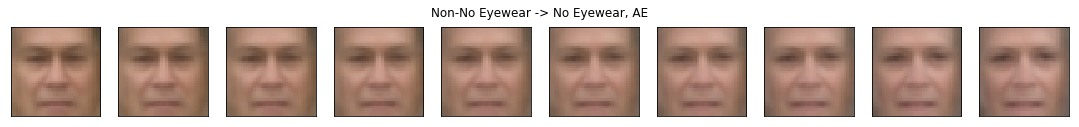

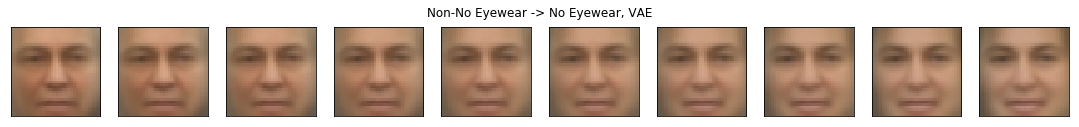

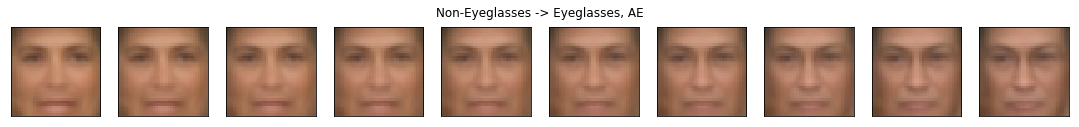

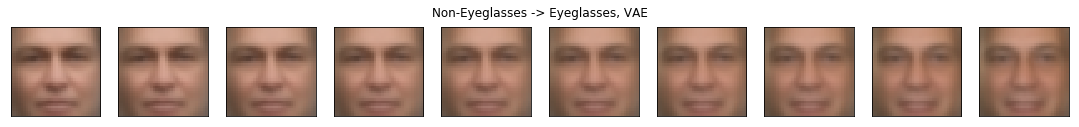

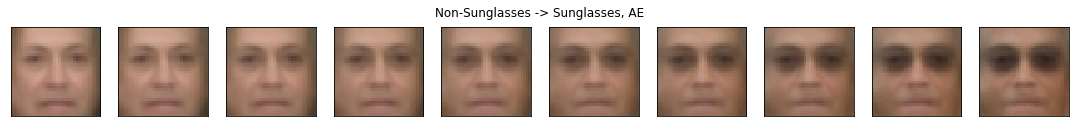

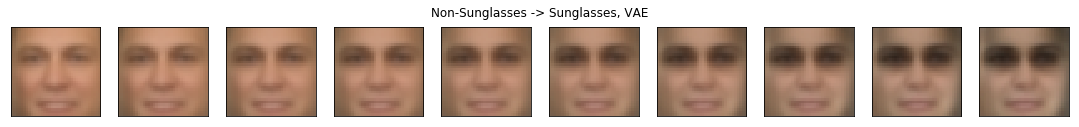

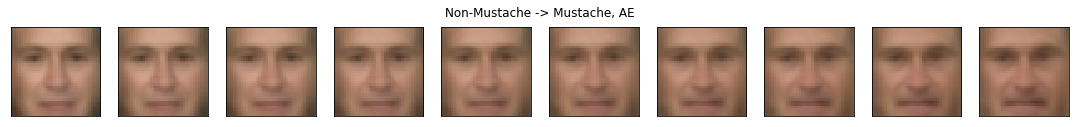

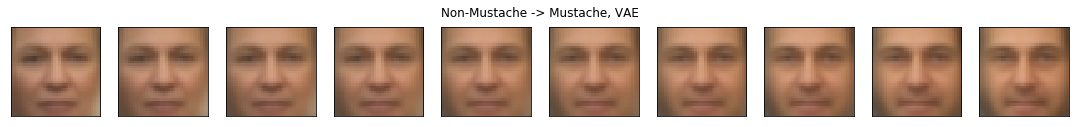

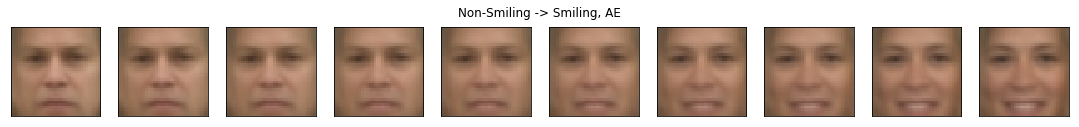

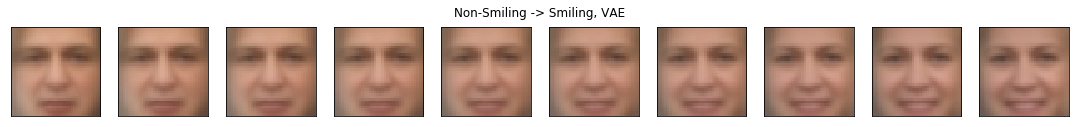

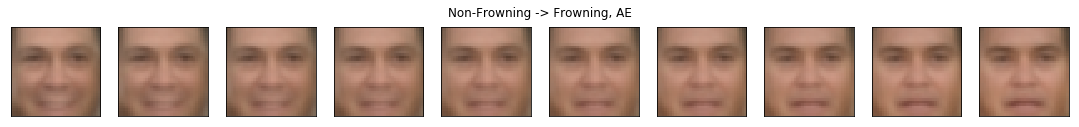

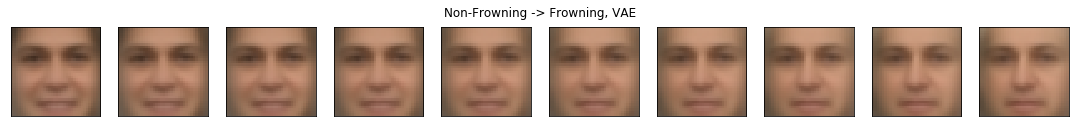

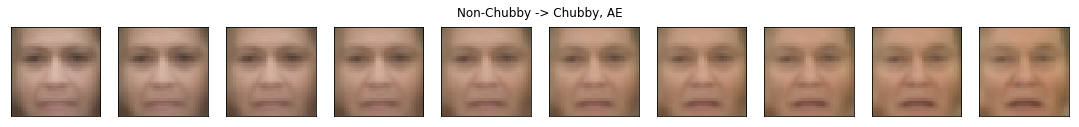

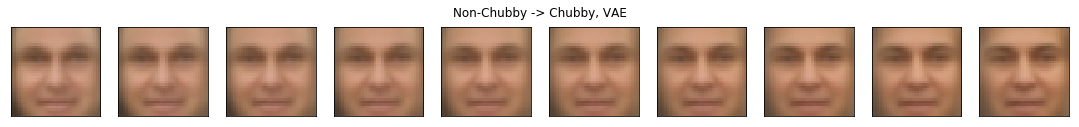

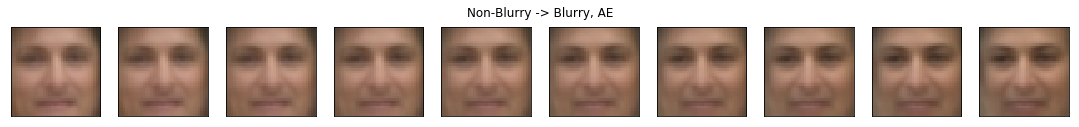

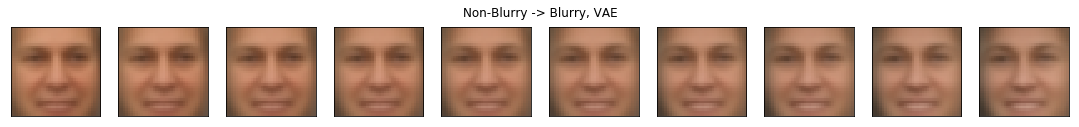

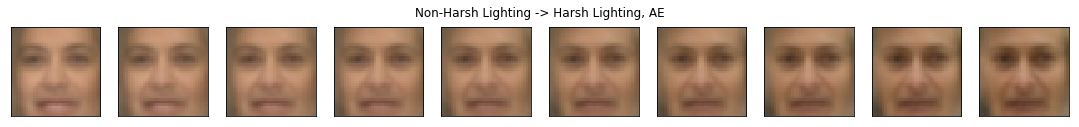

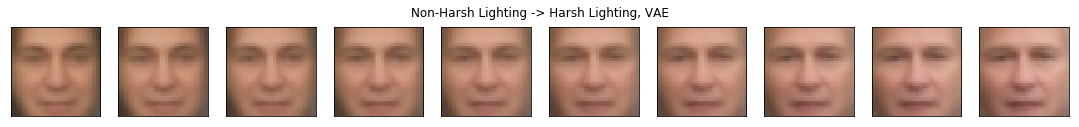

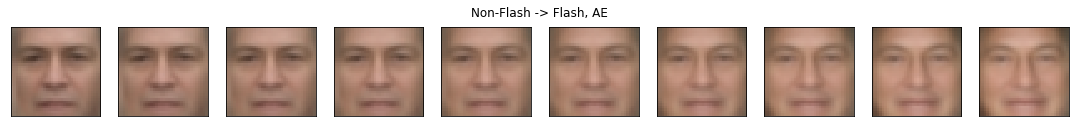

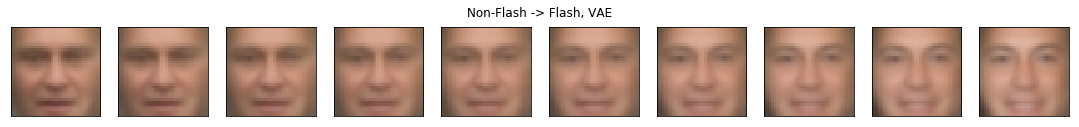

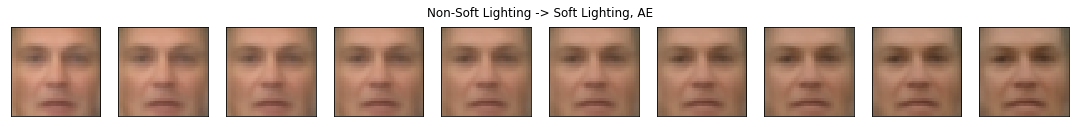

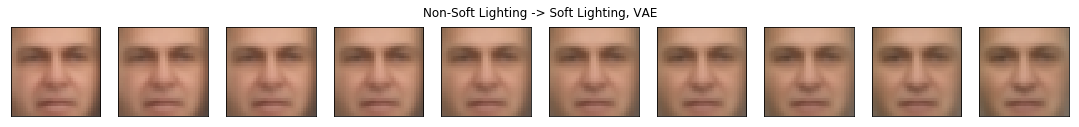

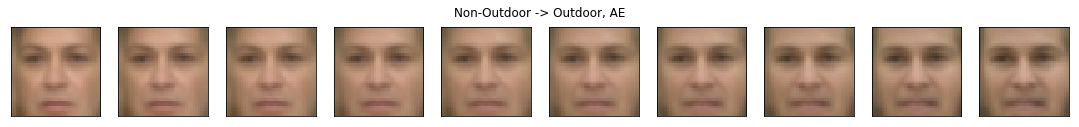

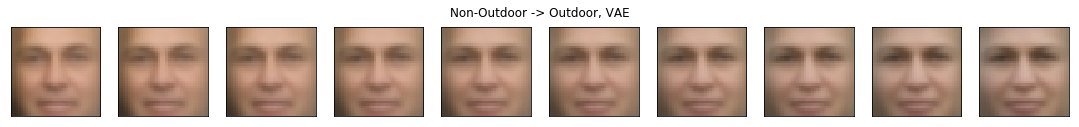

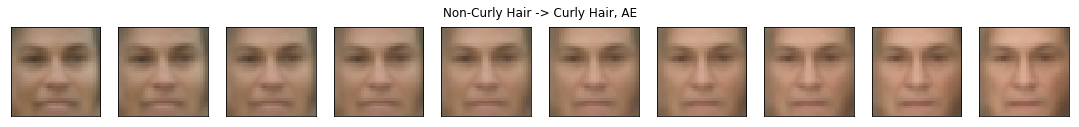

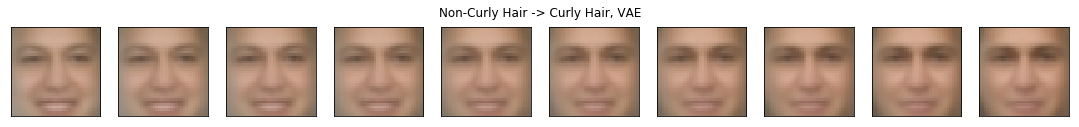

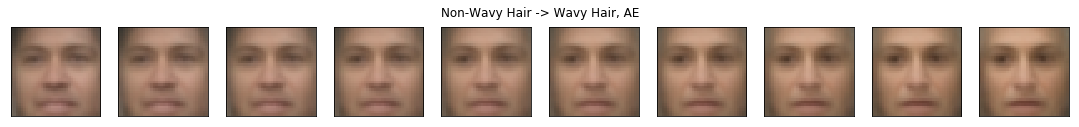

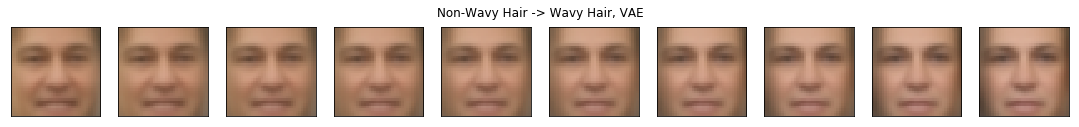

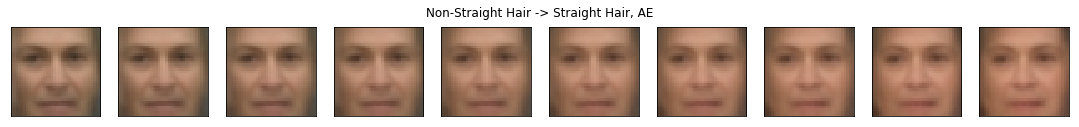

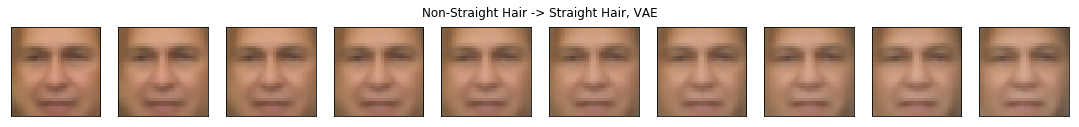

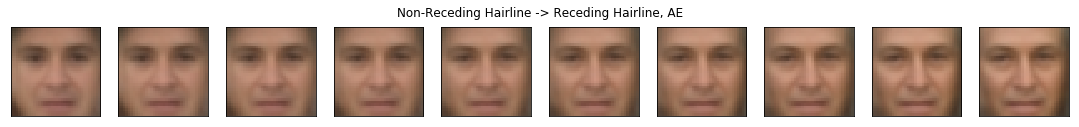

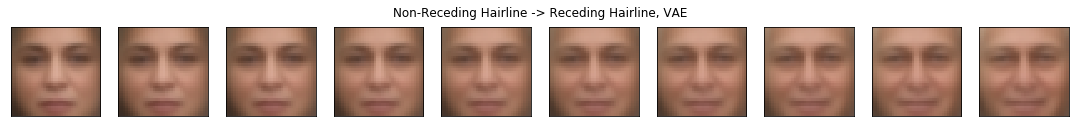

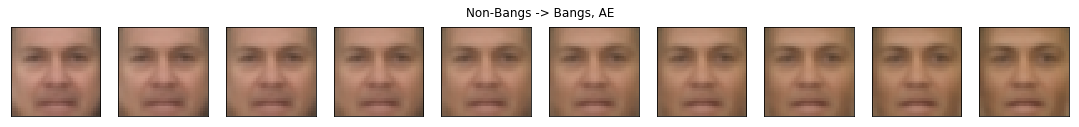

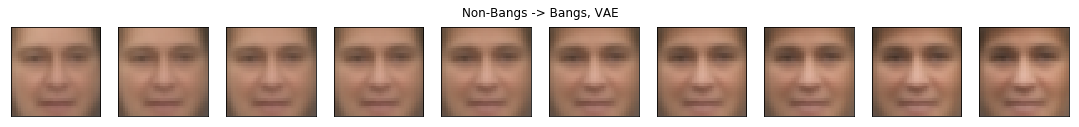

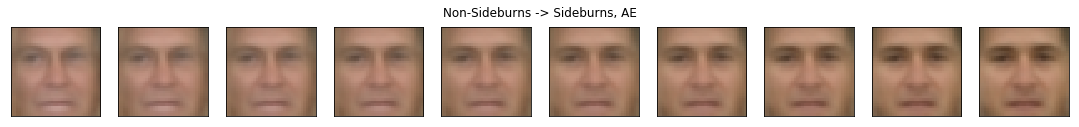

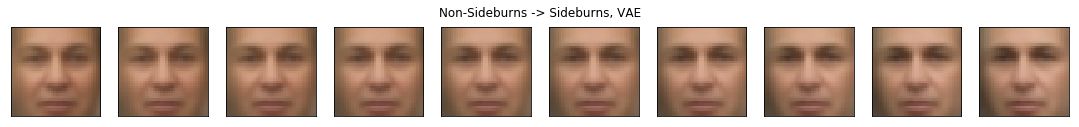

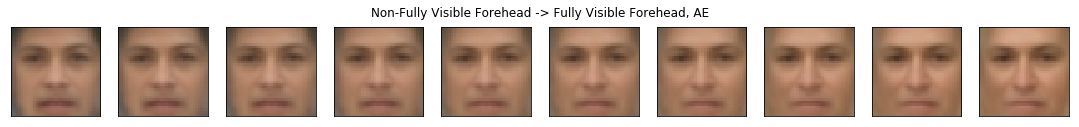

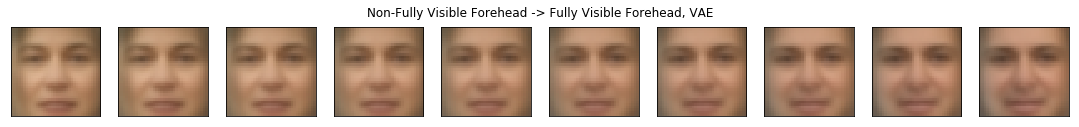

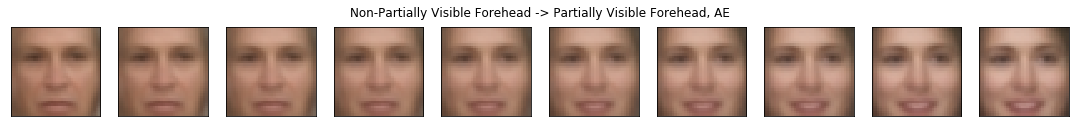

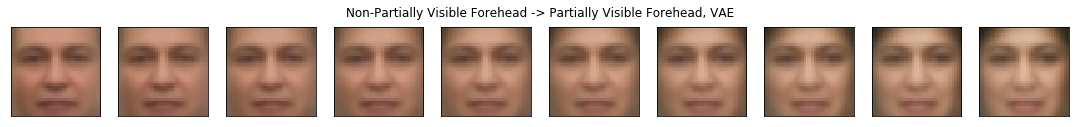

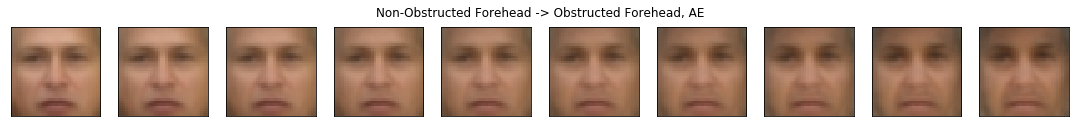

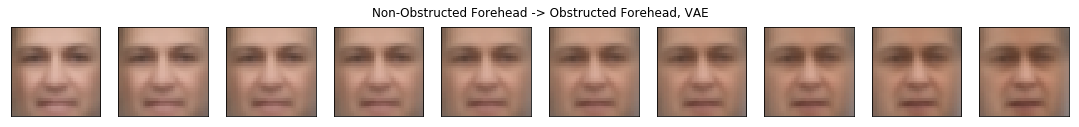

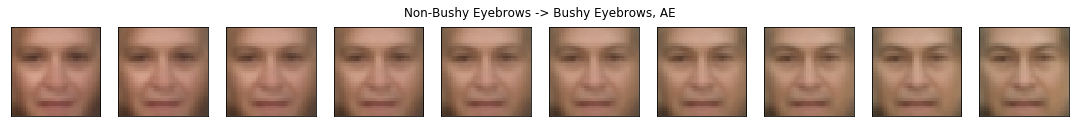

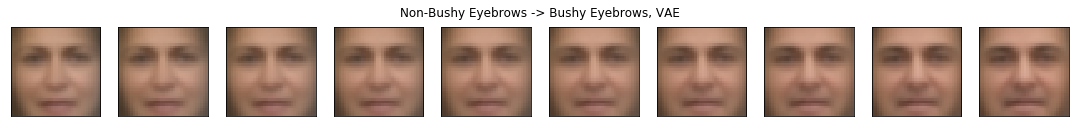

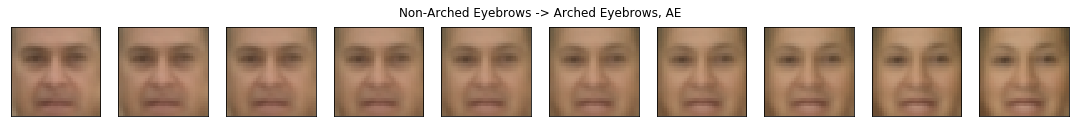

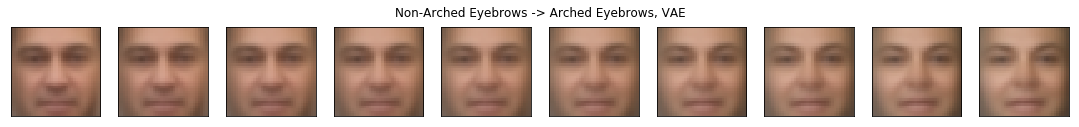

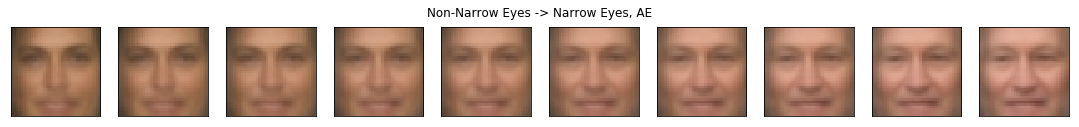

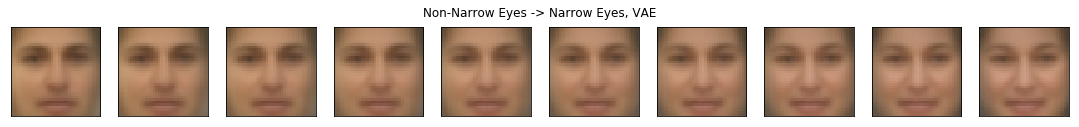

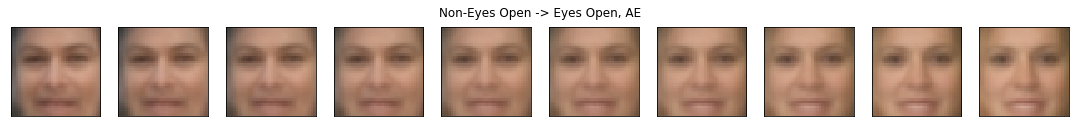

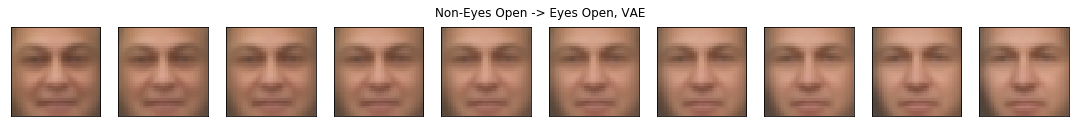

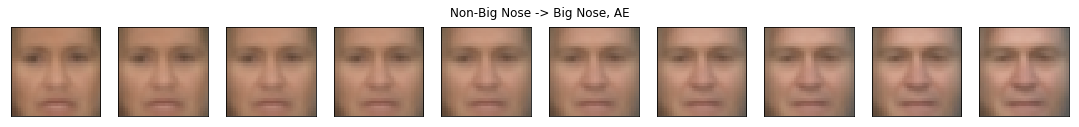

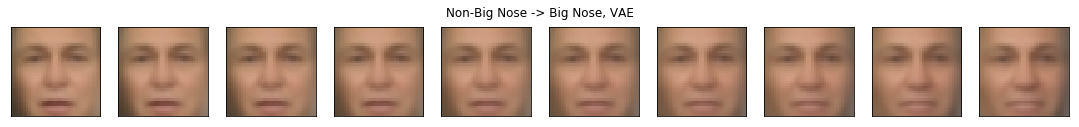

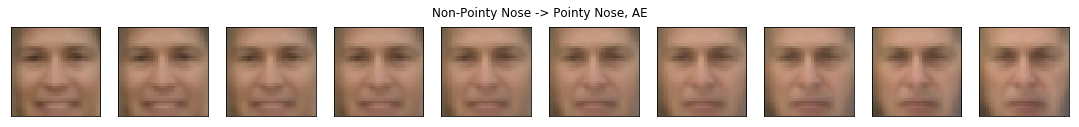

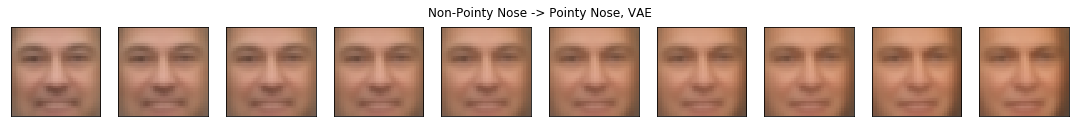

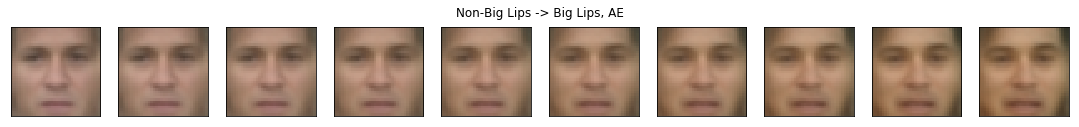

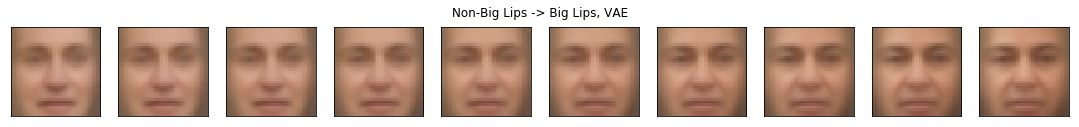

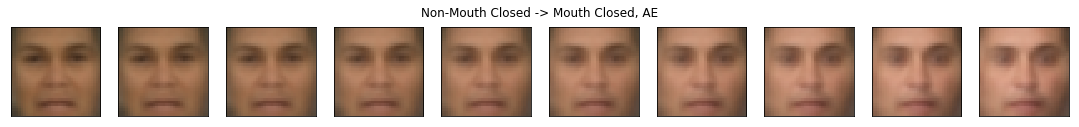

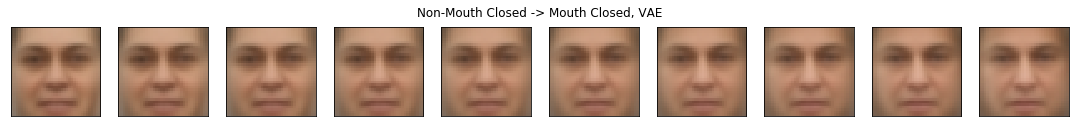

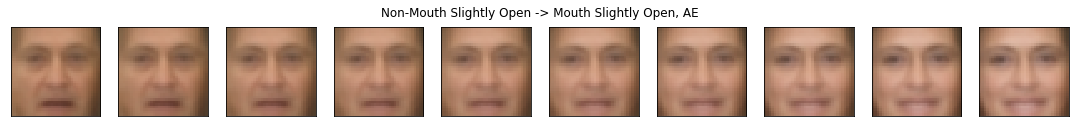

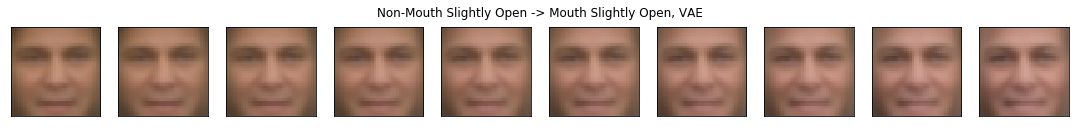

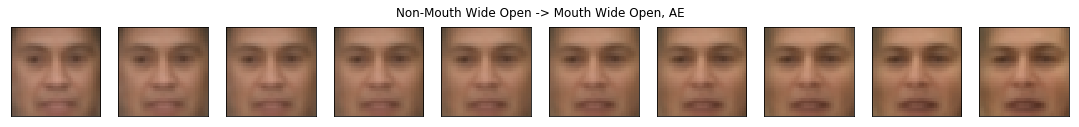

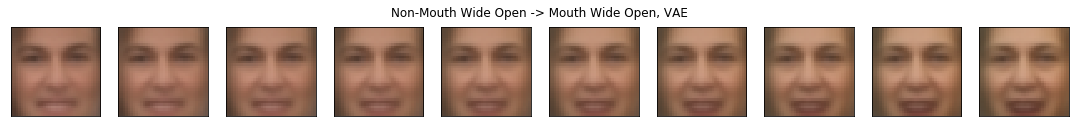

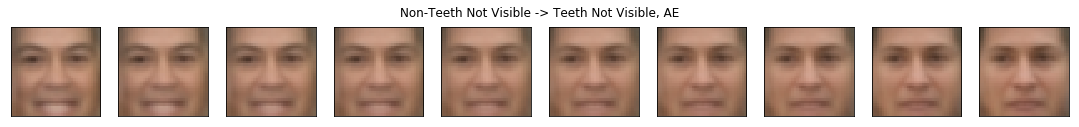

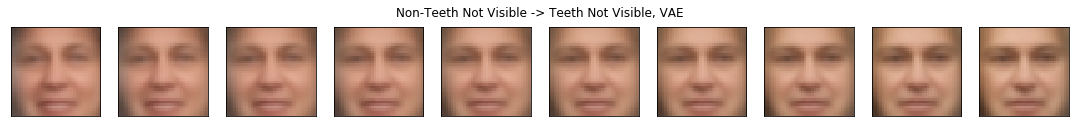

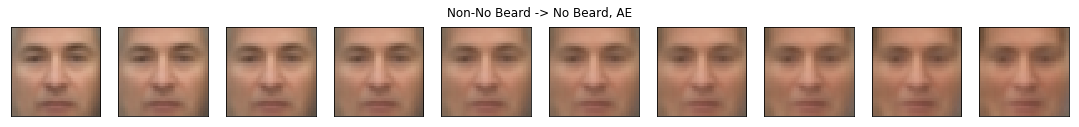

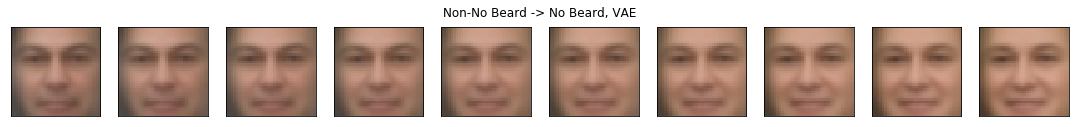

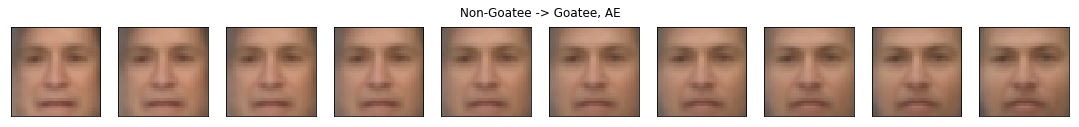

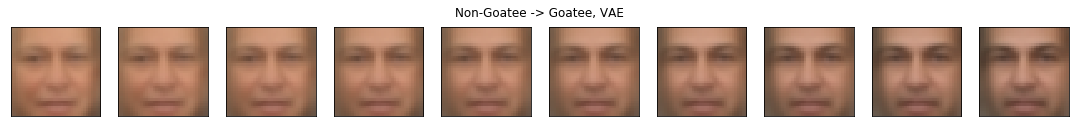

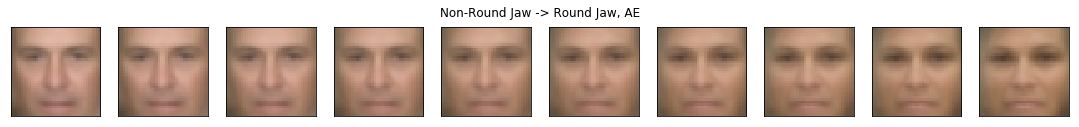

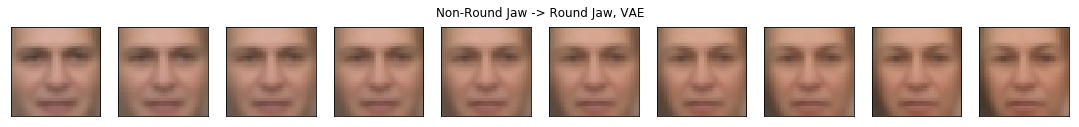

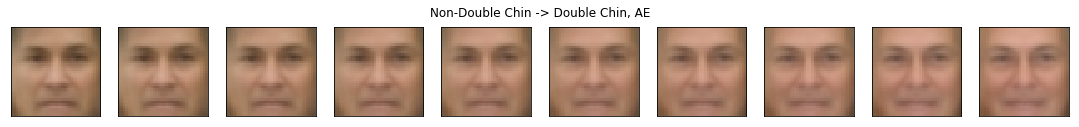

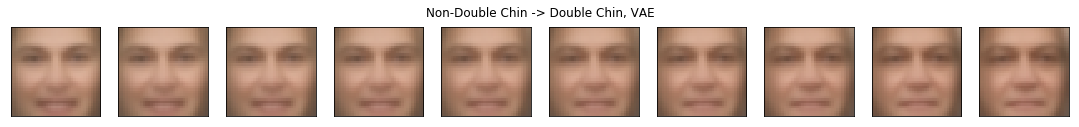

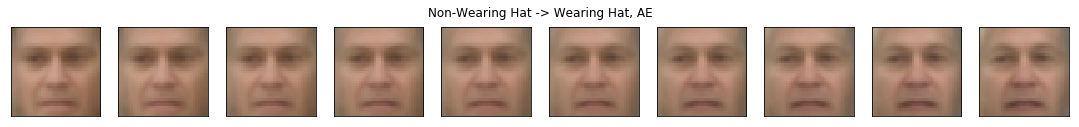

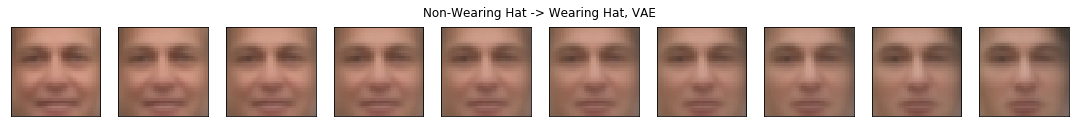

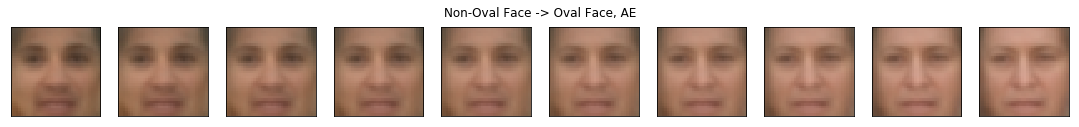

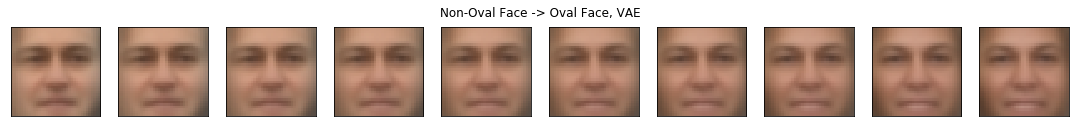

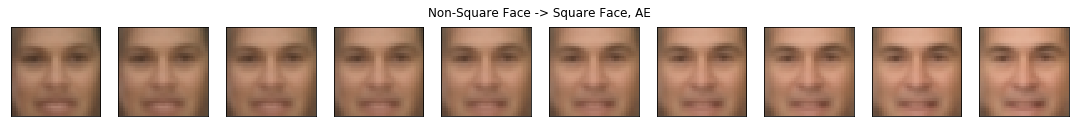

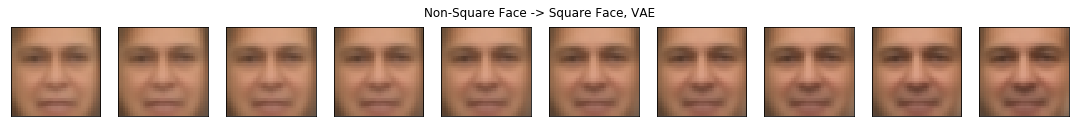

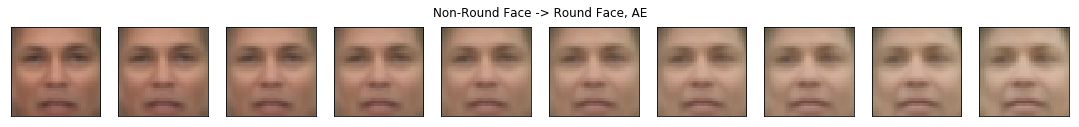

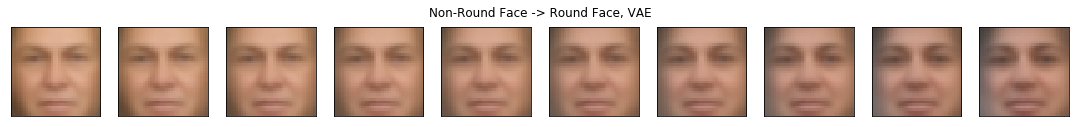

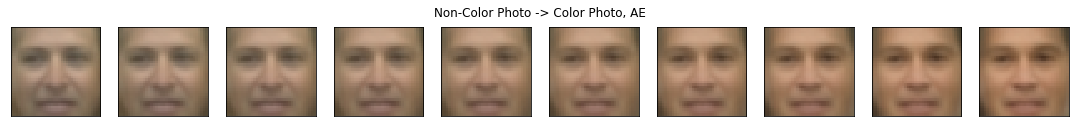

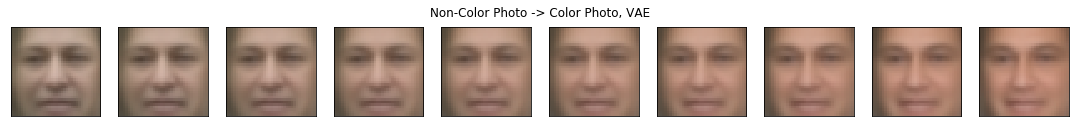

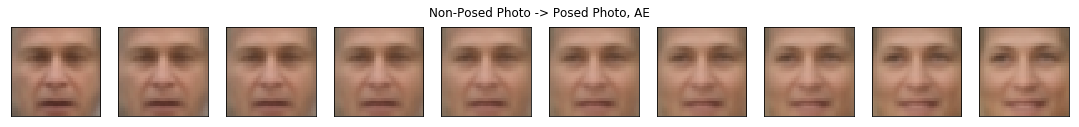

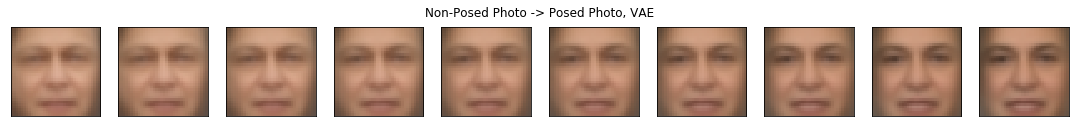

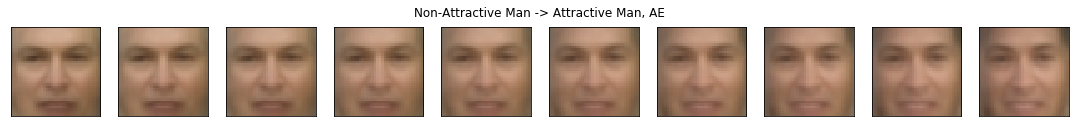

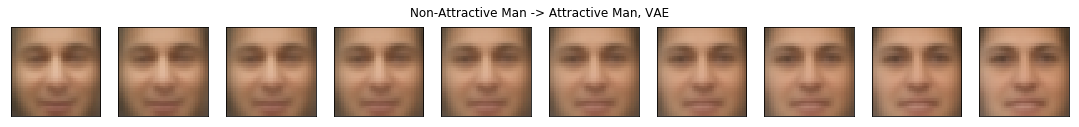

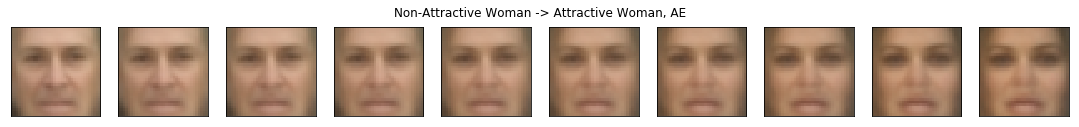

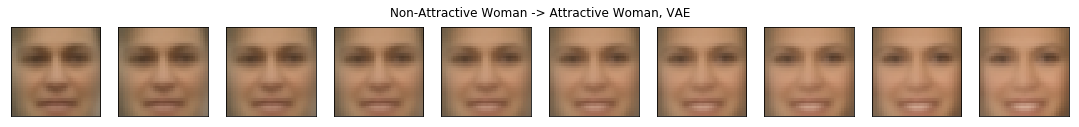

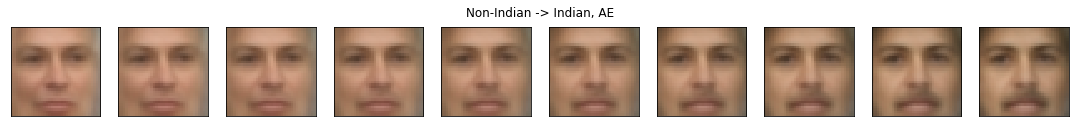

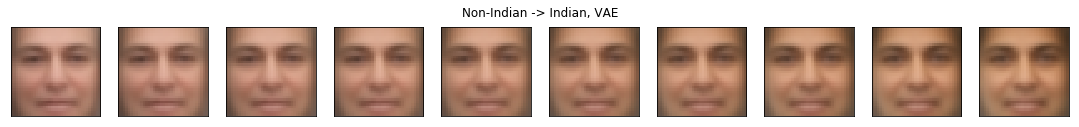

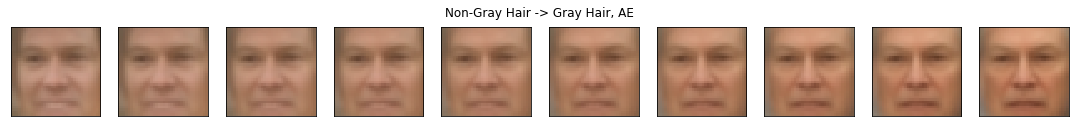

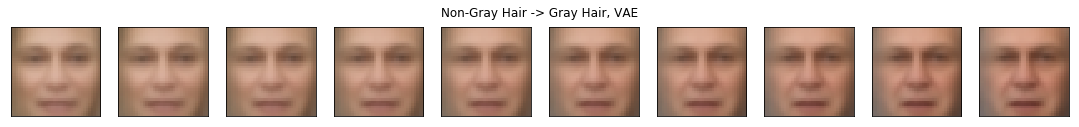

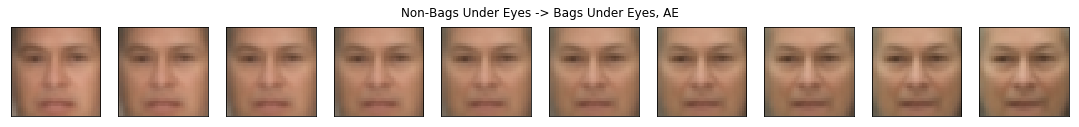

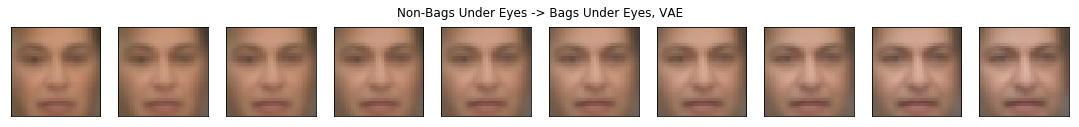

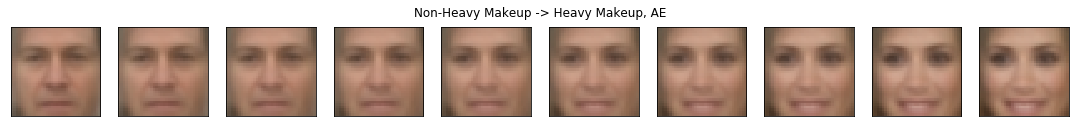

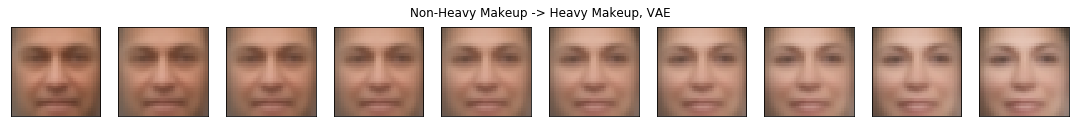

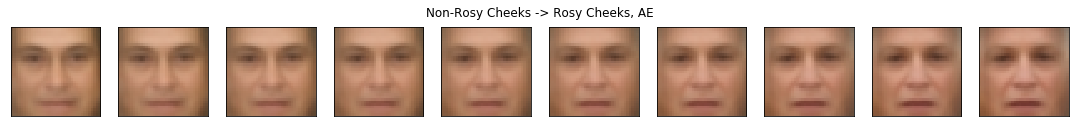

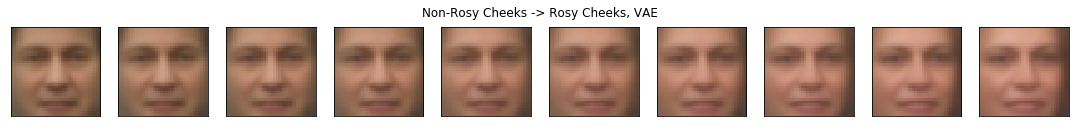

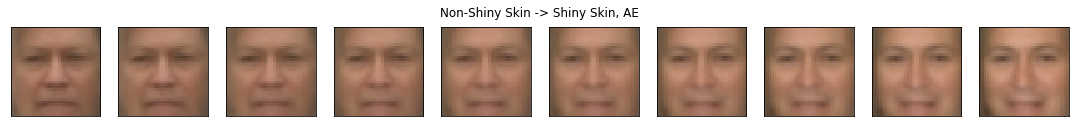

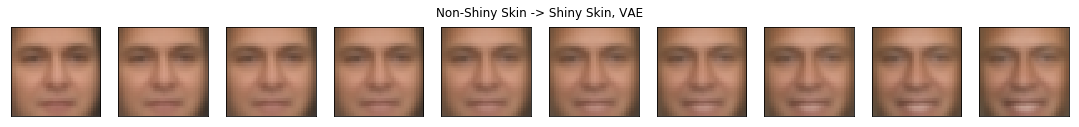

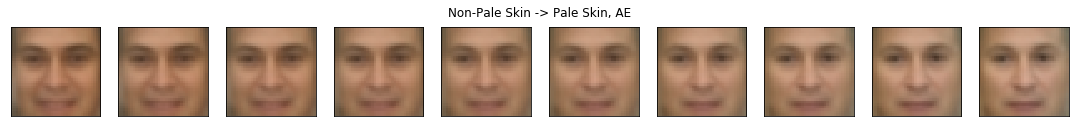

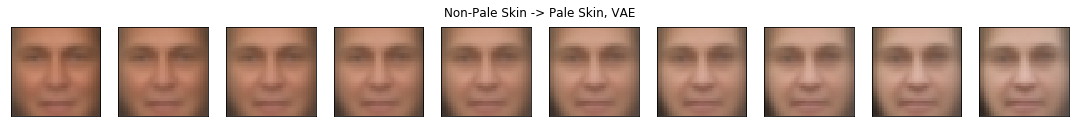

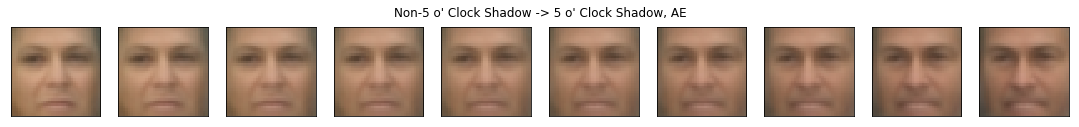

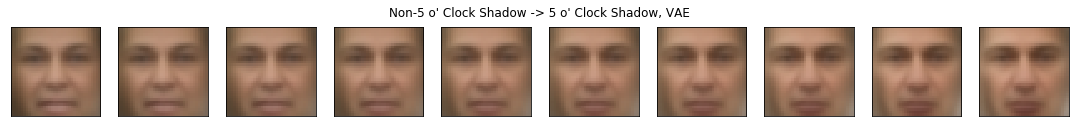

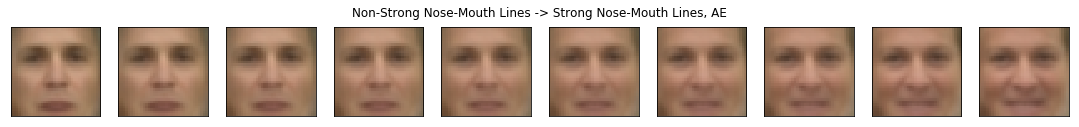

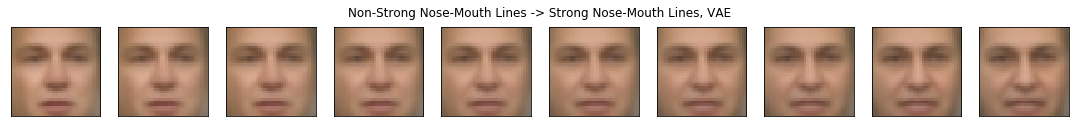

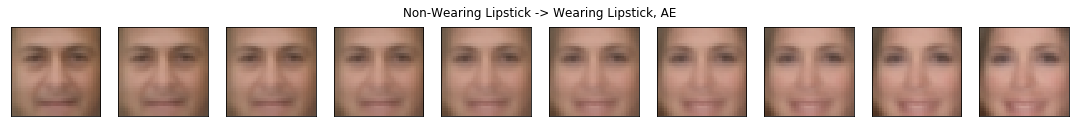

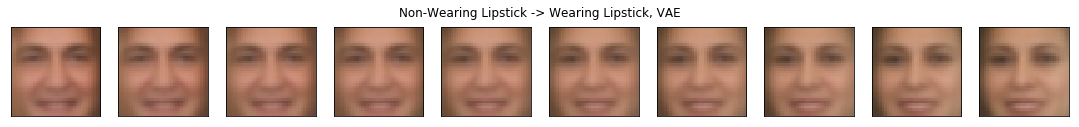

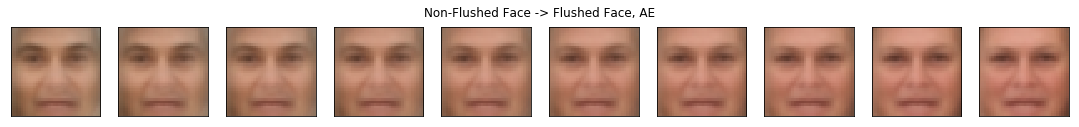

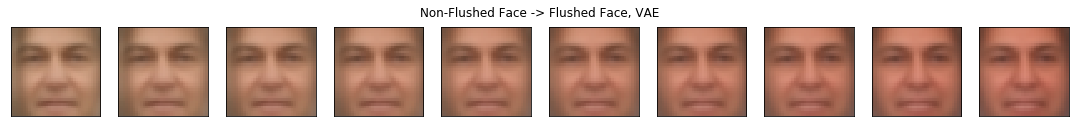

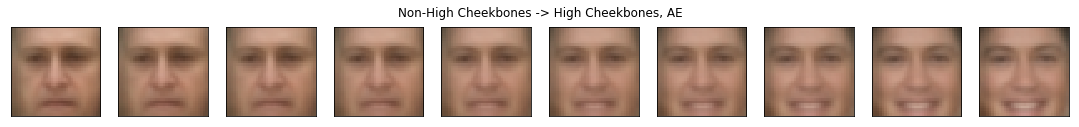

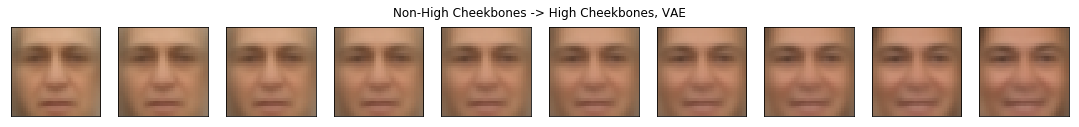

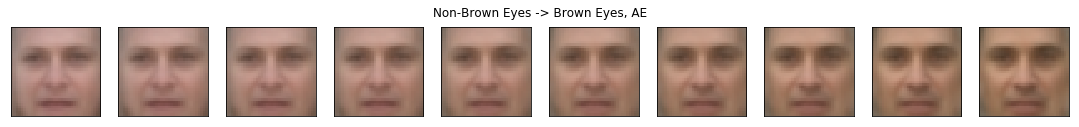

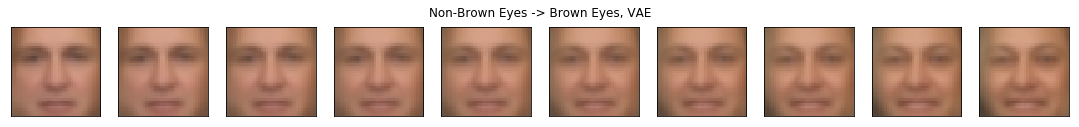

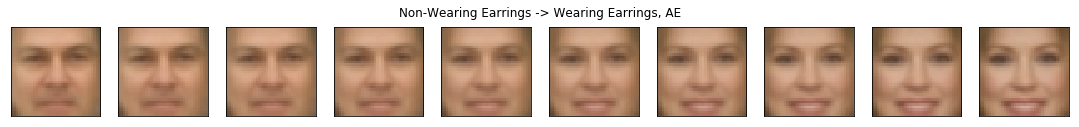

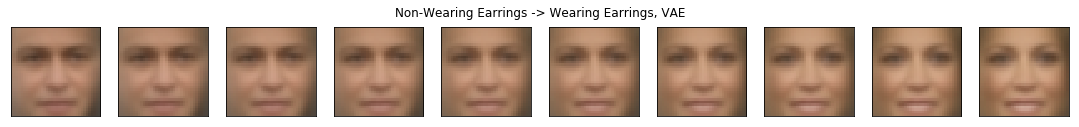

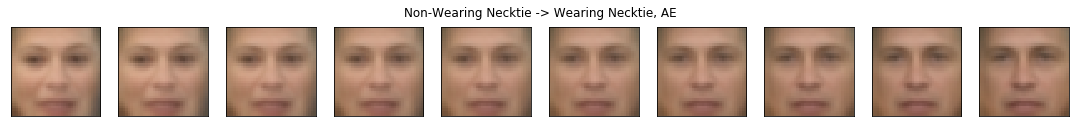

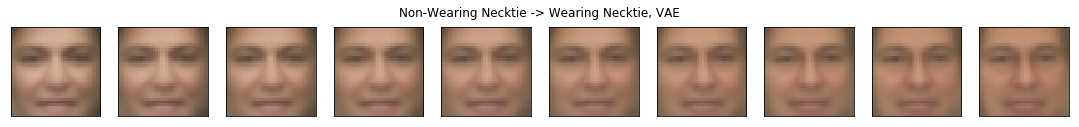

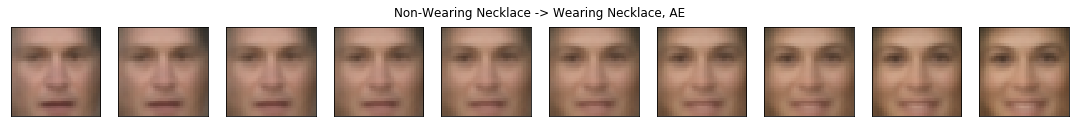

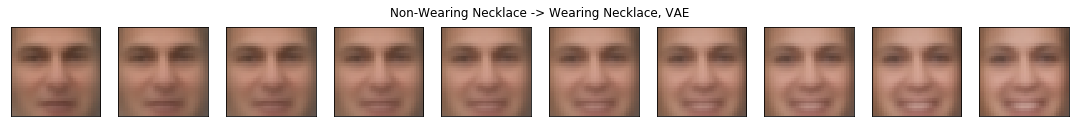

In [56]:
for attribute in attrs.columns:
    attr_transform(attribute, autoencoder)
    attr_transform(attribute, vae)

Sunglasses are creepy :D